In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import joblib
from mlxtend.frequent_patterns import apriori, association_rules

# Cargar los datos

In [267]:
# Usar el archivo correcto definido en DATA_FILE
data_df = pd.read_csv('atelier-datshet-2024-transacciones.csv')
df = pd.DataFrame(data_df)

In [268]:
df

,transaccion_id,fecha_transaccion,tipo_transaccion,estado,monto_total,metodo_pago,cliente_nombre,cliente_telefono,cliente_localidad,producto_id,...,vestido_en_oferta,vestido_condicion,vestido_rating_promedio,vestido_review_count,fecha_entrega,fecha_devolucion,multa_aplicada,reseña_rating,reseña_comentario,fecha_reseña
0,687e0e6d2d8655b05b08c3aa,2023-06-17 04:05:39,Venta,Completada,500,transferencia_bancaria,adriana.romero@example.com,1234567817,San Felipe Orizatlán,687c145a555de7433ad30a81,...,False,Excelente,3.5,3,2023-06-17 13:05:39,NaN,0,5,¡Absolutamente precioso! Recibí muchos cumplidos.,2023-07-06 04:05:39
1,687e0e6d2d8655b05b08c3af,2023-06-14 03:45:56,Venta,Completada,1321,tarjeta_debito,ana.lopez@example.com,1234567891,Atlapeza,687c1894555de7433ad30a9b,...,False,Excelente,4.3,10,2023-06-14 13:45:56,NaN,0,3,"Buena opción por el precio, el servicio fue co...",2023-07-17 03:45:56
2,687e0e6d2d8655b05b08c3b0,2023-09-19 04:34:31,Venta,Completada,2300,tarjeta_debito,maria.gonzalez@example.com,1234567893,Atlapeza,687c0574555de7433ad30a3f,...,False,Nuevo,4.6,10,2023-09-19 22:34:31,NaN,0,1,"La experiencia fue regular, no estoy segura de...",2023-10-28 04:34:31
3,687e0e6d2d8655b05b08c3b6,2023-06-13 03:29:14,renta,Completada,1318,efectivo,sheldon@gmail.com,5551234567,Platón Sánchez,687e0d4b8639b437a0e4877d,...,False,Nuevo,3.9,8,2023-06-13 23:29:14,2023-06-28 23:29:14,0,5,¡Absolutamente precioso! Recibí muchos cumplidos.,2023-07-18 03:29:14
4,687e0e6d2d8655b05b08c3ba,2023-06-10 06:33:29,renta,Completada,800,efectivo,maria.gonzalez@example.com,1234567893,Atlapeza,687e0dd08639b437a0e48790,...,False,Nuevo,4.6,10,2023-06-10 14:33:29,2023-06-21 14:33:29,0,5,"Un acierto total, justo lo que buscaba y a un ...",2023-06-25 06:33:29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,687e0e6d2d8655b05b08c580,2025-10-23 05:02:59,Venta,Completada,1200,tarjeta_debito,regina.ortega@example.com,1234567826,Tlachinol,687e0d4b8639b437a0e48771,...,False,Nuevo,4.0,9,2025-10-24 00:02:59,NaN,0,4,"El vestido superó mis expectativas, ¡lo recomi...",2025-11-27 05:02:59
838,687e0e6d2d8655b05b08c584,2025-06-18 04:06:50,renta,Completada,584,transferencia_bancaria,ia.perez@example.com,1234567897,Chalma,687e0dd08639b437a0e487b0,...,False,Nuevo,4.3,10,2025-06-19 00:06:50,2025-06-23 00:06:50,0,4,"El vestido superó mis expectativas, ¡lo recomi...",2025-06-29 04:06:50
839,687e0e6d2d8655b05b08c58d,2025-12-10 12:26:49,Venta,Completada,2900,tarjeta_credito,20221076@uthh.edu.mx,7712232323,San Felipe Orizatlán,687e0d4b8639b437a0e4877e,...,False,Nuevo,4.7,16,2025-12-10 23:26:49,NaN,0,4,¡Absolutamente precioso! Recibí muchos cumplidos.,2025-12-24 12:26:49
840,687e0e6d2d8655b05b08c590,2025-08-06 06:41:42,Venta,Completada,3000,tarjeta_credito,ana.lopez@example.com,1234567891,Atlapeza,687e0d4b8639b437a0e48770,...,False,Nuevo,4.8,6,2025-08-07 06:41:42,NaN,0,5,"La tela es de muy buena calidad, y el vestido ...",2025-08-17 06:41:42


In [269]:
    # print("Información inicial del DataFrame:")
    # df.info()# 1. Filtrar solo las columnas necesarias para reglas de asociación
    # df_rules = df[['transaccion_id', 'producto_nombre', 'cantidad_comprada']]
    
    # # 2. Crear la "cesta": filas = transacción, columnas = producto, valores = cantidad total
    # basket = df_rules.groupby(['transaccion_id', 'producto_nombre'])['cantidad_comprada'].sum().unstack().fillna(0)
    
    # # 3. Convertir a binario: 1 = comprado, 0 = no comprado
    # basket = basket.applymap(lambda x: 1 if x > 0 else 0)
    
    # # Mostrar las primeras filas
    # print("🧺 Matriz lista para Apriori:")
    # print(basket.head())


In [270]:

# 4. Preprocesamiento de datos
df.dropna(subset=['producto_talla', 'producto_color', 'producto_temporada', 'vestido_estilo', 'vestido_condicion'], inplace=True)
df['cantidad_comprada'] = df['cantidad_comprada'].astype(int)

# 6. Preparar datos para análisis de asociación
atributos = ['producto_talla', 'producto_color', 'producto_temporada', 'vestido_estilo', 'vestido_condicion']
df_analisis = df[['transaccion_id'] + atributos].copy()

list_of_attributes = []
for attr in atributos:
    list_of_attributes.append(df_analisis[attr].apply(lambda x: f"{attr}_{x}"))

items = pd.concat(list_of_attributes, ignore_index=True)

df_basket = pd.DataFrame({
    'transaccion_id': df_analisis['transaccion_id'].repeat(len(atributos)).reset_index(drop=True),
    'item': items
})

basket = (df_basket.groupby(['transaccion_id', 'item'])['item']
          .count()
          .unstack(fill_value=0)
          .reset_index()
          .set_index('transaccion_id'))

basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# 1. Filtrar productos poco frecuentes (atributos)
min_transactions = 2 # Ajustado para el ejemplo
product_counts = basket.sum(axis=0)
products_to_keep = product_counts[product_counts >= min_transactions].index
basket_filtered = basket[products_to_keep]

# 2. Convertir a booleanos explícitamente
basket_bool = basket_filtered.astype(bool)

# 3. Aplicar Apriori con parámetros optimizados
try:
    frequent_itemsets = apriori(basket_bool,
                                min_support=0.05, # min_support ajustado para el ejemplo
                                use_colnames=True,
                                low_memory=True,
                                max_len=3,
                                verbose=1)

    print(f"\nItemsets frecuentes encontrados: {len(frequent_itemsets)}")

    # 4. Generar y analizar reglas con filtros estrictos
    if not frequent_itemsets.empty:
        rules = association_rules(frequent_itemsets,
                                 metric="lift",
                                 min_threshold=1.5)

        print(f"\nReglas generadas: {len(rules)}")

        # --- AHORA VAMOS A MOSTRAR LAS REGLAS DE FORMA CLARA ---

        # 1. Filtrar las reglas más fuertes (lift > 1.5, confidence > 0.6)
        strong_rules = rules[(rules['lift'] > 1.5) & (rules['confidence'] > 0.6)]
        
        # 2. Ordenar las reglas por 'lift' de forma descendente
        strong_rules = strong_rules.sort_values(['lift', 'confidence'], ascending=[False, False])
        
        if not strong_rules.empty:
            print("\n--- Las 5 reglas de asociación más fuertes (ordenadas por lift) ---")
            # Mostrar solo las columnas más importantes para la interpretación
            print(strong_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())
        else:
            print("No se encontraron reglas fuertes con los filtros de lift > 1.5 y confidence > 0.6.")
            print("Aquí están las primeras 5 reglas generadas (sin filtros adicionales):")
            print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head())

    else:
        print("\nNo se encontraron itemsets frecuentes con los parámetros actuales.")

except MemoryError:
    print("Error de memoria. Intenta con:")
    print("- Un min_support más alto")
    print("- Un max_len más bajo")
    print("- Filtrar más productos poco frecuentes")

C:\Users\r3152\AppData\Local\Temp\ipykernel_15252\3836401210.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


Processing 4 combinations | Sampling itemset size 32

Itemsets frecuentes encontrados: 27

Reglas generadas: 26

--- Las 5 reglas de asociación más fuertes (ordenadas por lift) ---
                      antecedents                consequents   support  \
15      (vestido_estilo_De Noche)    (vestido_estilo_Casual)  0.112827   
14        (vestido_estilo_Casual)  (vestido_estilo_De Noche)  0.112827   
5              (producto_talla_S)         (producto_talla_M)  0.160333   
4              (producto_talla_M)         (producto_talla_S)  0.160333   
12  (vestido_condicion_Excelente)  (vestido_condicion_Nuevo)  0.054632   

    confidence      lift  
15    0.785124  5.085188  
14    0.730769  5.085188  
5     0.944056  4.937237  
4     0.838509  4.937237  
12    0.978723  4.905268  


# --- Análisis de Dispersión Inicial ---

# Seleccionar las columnas numéricas para el gráfico de dispersión


Primeras 5 filas de los datos para el gráfico de dispersión (Cantidad Comprada, Monto Total):
[[   1  500]
 [   1 1321]
 [   1 2300]
 [   1 1318]
 [   1  800]]


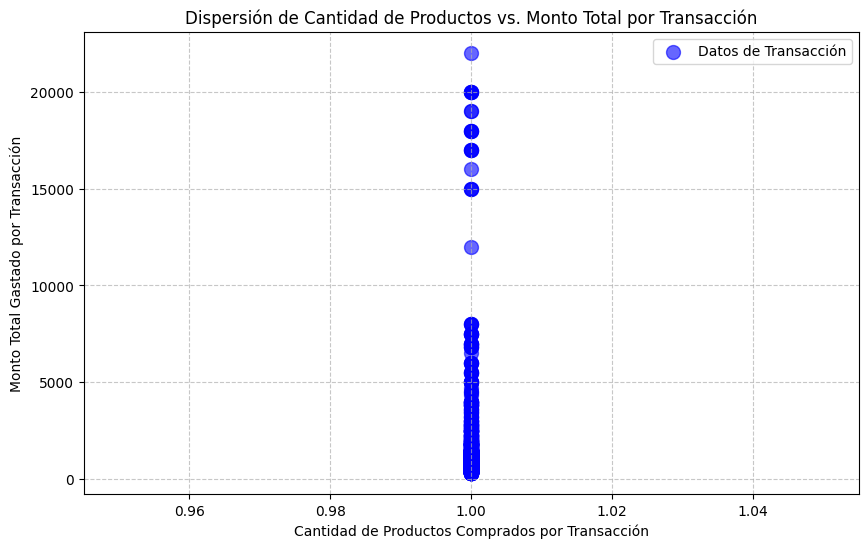

In [271]:
X_scatter = df[['cantidad_comprada', 'monto_total']].values
print("\nPrimeras 5 filas de los datos para el gráfico de dispersión (Cantidad Comprada, Monto Total):")
print(X_scatter[0:5, :])

plt.figure(figsize=(10, 6))
plt.scatter(X_scatter[:, 0], X_scatter[:, 1], s=100, c='blue', alpha=0.6, label='Datos de Transacción')
plt.xlabel('Cantidad de Productos Comprados por Transacción')
plt.ylabel('Monto Total Gastado por Transacción')
plt.title('Dispersión de Cantidad de Productos vs. Monto Total por Transacción')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# --- Método del Codo para K-Means ---
# Calcular la inercia para diferentes números de clusters

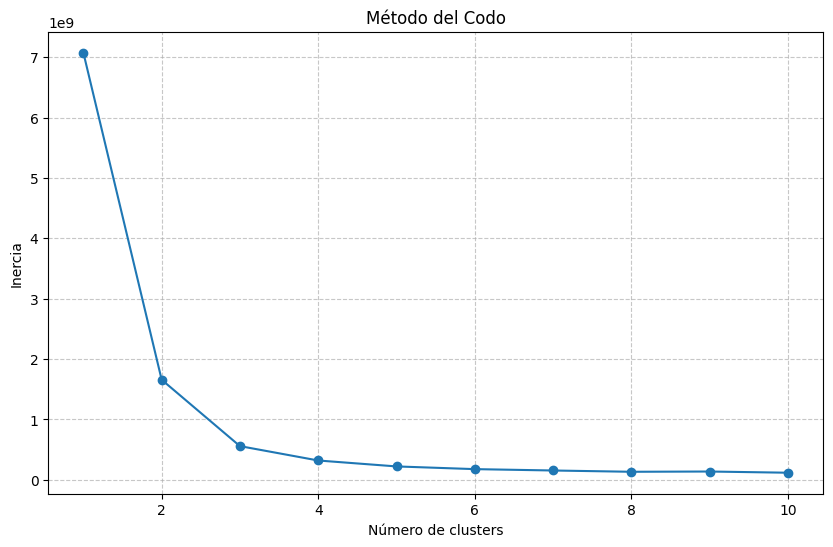

In [272]:
inercia = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='random', max_iter=300, n_init=10, tol=1e-04, random_state=0)
    km.fit(X_scatter)
    inercia.append(km.inertia_)

# Graficar el método del codo
plt.figure(figsize=(10, 6)) # Ajustado el tamaño para mejor visualización
plt.plot(range(1, 11), inercia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# --- Dendrograma para Agrupamiento Jerárquico ---

In [273]:
# Seleccionar las columnas numéricas relevantes para el clustering jerárquico
X_dendrogram = df[['cantidad_comprada', 'monto_total']].values

# Convertir a DataFrame para muestreo
X_dendrogram_df = pd.DataFrame(X_dendrogram, columns=['cantidad_comprada', 'monto_total'])

# Determinar el tamaño de la muestra (para datasets grandes)
sample_size = min(500, len(X_dendrogram_df))
muestra = X_dendrogram_df.sample(n=sample_size, random_state=0).values



# Crear el dendrograma

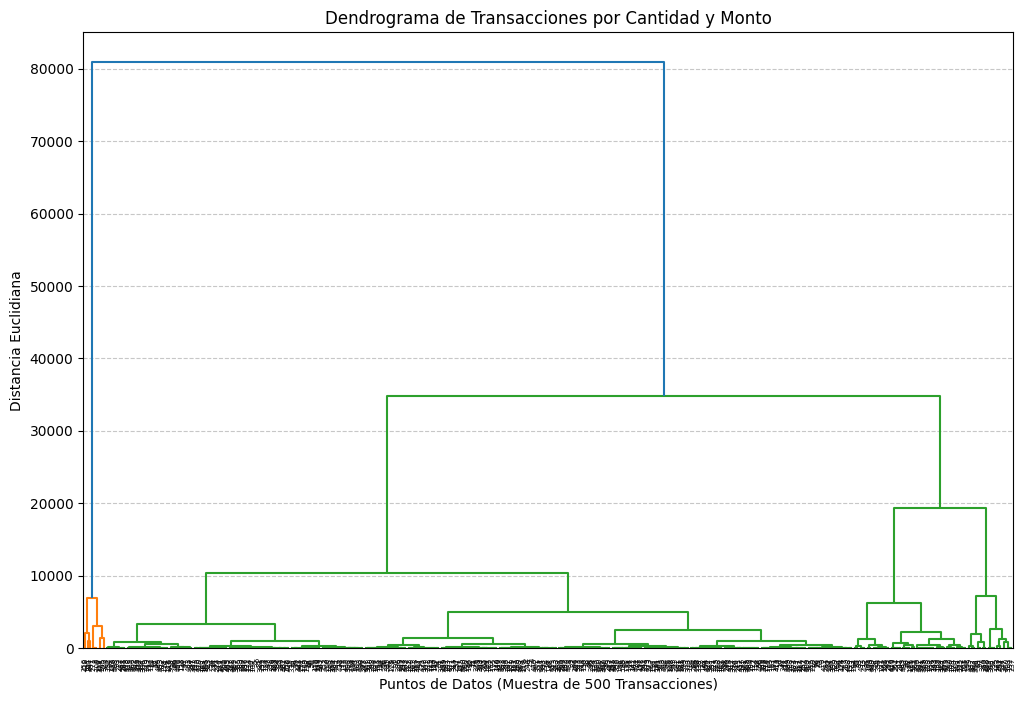

Dendrograma generado a partir de una muestra de 500 puntos de datos.


In [274]:
plt.figure(figsize=(12, 8))
dendrogram = sch.dendrogram(sch.linkage(muestra, method='ward'))
plt.title('Dendrograma de Transacciones por Cantidad y Monto')
plt.xlabel(f'Puntos de Datos (Muestra de {sample_size} Transacciones)')
plt.ylabel('Distancia Euclidiana')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print(f"Dendrograma generado a partir de una muestra de {sample_size} puntos de datos.")


# --- Aplicar K-Means con el número óptimo de clusters (ej. 3, basado en el método del codo) ---

In [275]:
# 1. Apply K-Means and assign transaction-level clusters to the original 'df'
num_clusters_kmeans = 3 # Adjust based on your elbow method
km = KMeans(n_clusters=num_clusters_kmeans, init='random', max_iter=300, n_init=10, tol=1e-04, random_state=0)
y_km = km.fit_predict(X_scatter) # X_scatter contains 'cantidad_comprada', 'monto_total' for transactions
df['cluster'] = y_km # This adds 'cluster' to your transaction DataFrame 'df'


# Visualizar los clusters

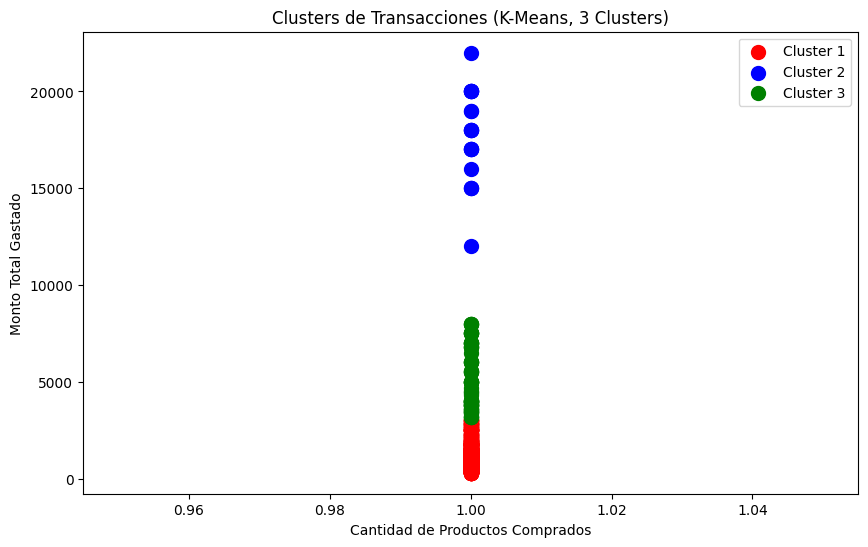

In [276]:
plt.figure(figsize=(10, 6))
plt.scatter(X_scatter[y_km == 0, 0], X_scatter[y_km == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(X_scatter[y_km == 1, 0], X_scatter[y_km == 1, 1], s=100, c='blue', label='Cluster 2')
plt.scatter(X_scatter[y_km == 2, 0], X_scatter[y_km == 2, 1], s=100, c='green', label='Cluster 3')
plt.xlabel('Cantidad de Productos Comprados') # Ajustado a los datos usados
plt.ylabel('Monto Total Gastado') # Ajustado a los datos usados
plt.title(f'Clusters de Transacciones (K-Means, {num_clusters_kmeans} Clusters)')
plt.legend()
plt.show()

# Asignar los resultados del clustering a una nueva columna 'cluster' en el DataFrame 'df'

In [277]:
df['cluster'] = y_km

# Obtener los clientes de los diferentes clusters (ejemplo)

In [278]:
print("\n--- Clientes por Cluster (Muestra) ---")
cluster_0_clientes = df[df['cluster'] == 0]['cliente_nombre'].head()
cluster_1_clientes = df[df['cluster'] == 1]['cliente_nombre'].head()
cluster_2_clientes = df[df['cluster'] == 2]['cliente_nombre'].head()

print("\nClientes del Clúster 0 (primeros 5):")
print(cluster_0_clientes)
print("\nClientes del Clúster 1 (primeros 5):")
print(cluster_1_clientes)
print("\nClientes del Clúster 2 (primeros 5):")
print(cluster_2_clientes)


--- Clientes por Cluster (Muestra) ---

Clientes del Clúster 0 (primeros 5):
0    adriana.romero@example.com
1         ana.lopez@example.com
2    maria.gonzalez@example.com
3             sheldon@gmail.com
4    maria.gonzalez@example.com
Name: cliente_nombre, dtype: object

Clientes del Clúster 1 (primeros 5):
38          lucia.torres@example.com
79     alejandra.paredes@example.com
83         valeria.rojas@example.com
85              20221076@uthh.edu.mx
120       adriana.romero@example.com
Name: cliente_nombre, dtype: object

Clientes del Clúster 2 (primeros 5):
31    daniela.mendoza@example.com
37     carmen.morales@example.com
41       lucia.torres@example.com
62      regina.ortega@example.com
68      regina.ortega@example.com
Name: cliente_nombre, dtype: object


# --- Crear DataFrame de Clientes Agregado ---

In [279]:
df_clientes = df.groupby('cliente_nombre').agg(
    num_transacciones=('transaccion_id', 'nunique'),
    monto_total_gastado=('monto_total', 'sum'),
    # Asumimos que un cliente cae en un solo clúster.
    # Si un cliente aparece en múltiples clústeres debido a cómo se hizo el clustering de transacciones,
    # esto tomará el primer clúster que encuentre para ese cliente.
    # Una aproximación más robusta sería re-clusterizar a nivel de cliente.
    cluster=('cluster', lambda x: x.mode()[0]) # Tomar el clúster más frecuente si un cliente tiene múltiples
).reset_index()

print("\nDataFrame 'df_clientes' agregado (primeras 5 filas):")
print(df_clientes.head())



DataFrame 'df_clientes' agregado (primeras 5 filas):
                  cliente_nombre  num_transacciones  monto_total_gastado  \
0           20221076@uthh.edu.mx                 31                58008   
1           20221129@uthh.edu.mx                 40                66528   
2     adriana.romero@example.com                 35                76233   
3  alejandra.paredes@example.com                 39                76634   
4          ana.lopez@example.com                 31                59444   

   cluster  
0        0  
1        0  
2        0  
3        0  
4        0  


# --- Preparación de Datos para el Clasificador ---
# Características (X) y variable objetivo (y) para el modelo

In [280]:
X_model = df_clientes[['num_transacciones', 'monto_total_gastado']]
y_model = df_clientes['cluster']

print("\nPrimeras filas de X (características para el modelo):")
print(X_model.head())
print("\nPrimeras filas de y (variable objetivo - clústeres):")
print(y_model.head())



Primeras filas de X (características para el modelo):
   num_transacciones  monto_total_gastado
0                 31                58008
1                 40                66528
2                 35                76233
3                 39                76634
4                 31                59444

Primeras filas de y (variable objetivo - clústeres):
0    0
1    0
2    0
3    0
4    0
Name: cluster, dtype: int32



# Escalar las características

In [281]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_model)
X_scaled_df = pd.DataFrame(X_scaled, columns=['num_transacciones', 'monto_total_gastado'])

print("\nDataFrame de Características Escaladas (X_scaled_df - primeras 5 filas):")
print(X_scaled_df.head())



DataFrame de Características Escaladas (X_scaled_df - primeras 5 filas):
   num_transacciones  monto_total_gastado
0          -0.172140            -0.180998
1           0.946773             0.257205
2           0.325154             0.756356
3           0.822449             0.776980
4          -0.172140            -0.107141


# --- Entrenamiento y Evaluación del Clasificador ---
# Dividir los datos en conjunto de entrenamiento y prueba

In [282]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y_model, test_size=0.2, random_state=0)


# Entrenar el clasificador (RandomForestClassifier)

In [283]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

# Predecir en el conjunto de prueba

In [284]:
y_pred = clf.predict(X_test)

# Evaluar el clasificador

In [285]:
print("\n--- Evaluación del Clasificador ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



--- Evaluación del Clasificador ---
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



# Opcional: Guardar el clasificador entrenado y el escalador

In [286]:
joblib.dump(clf, 'customer_cluster_classifier_atlier.pkl')
joblib.dump(scaler, 'scaler_atlier.pkl')
print("\nClasificador y escalador guardados como 'customer_cluster_classifier.pkl' y 'scaler.pkl'.")



Clasificador y escalador guardados como 'customer_cluster_classifier.pkl' y 'scaler.pkl'.



# --- PASO ADICIONAL DEL USUARIO: Cargar y preparar para nuevas transacciones y recomendaciones ---

# --- Cargar el modelo y escalador (si estás en un nuevo script o sesión) ---

In [287]:
# # --- FUNCIONES DE RECOMENDACIÓN (ACTUALIZADAS PARA INCLUIR REGLAS) ---

# # Asegúrate de que 'rules' esté definido antes de usarlo
# try:
#     rules
# except NameError:
#     import pandas as pd
#     import joblib
#     try:
#         rules = joblib.load('rules.pkl')
#         print("Reglas de asociación cargadas exitosamente desde 'rules.pkl'.")
#     except Exception:
#         print("Advertencia: 'rules' no está definido y no se pudo cargar 'rules.pkl'. Se usará un DataFrame vacío.")
#         rules = pd.DataFrame(columns=['antecedents', 'consequents', 'confidence'])

# def obtener_productos_top_frecuencia(cluster_id, df_transacciones_con_cluster_local, num_productos=3):
#     """Obtiene los productos más frecuentes para un clúster dado."""
#     # Usar 'cluster_x' para filtrar
#     if cluster_id not in df_transacciones_con_cluster_local['cluster_x'].unique():
#         return []
#     cluster_df_filtered = df_transacciones_con_cluster_local[df_transacciones_con_cluster_local['cluster_x'] == cluster_id]
#     top_productos = cluster_df_filtered['producto_nombre'].value_counts().head(num_productos)
#     return top_productos.index.tolist()

# def obtener_productos_top_monto(cluster_id, df_transacciones_con_cluster_local, num_productos=3):
#     """Obtiene los productos que generan mayor monto para un clúster dado."""
#     # Usar 'cluster_x' para filtrar
#     if cluster_id not in df_transacciones_con_cluster_local['cluster_x'].unique():
#         return []
#     cluster_df_filtered = df_transacciones_con_cluster_local[df_transacciones_con_cluster_local['cluster_x'] == cluster_id]
#     top_monto_productos = cluster_df_filtered.groupby('producto_nombre')['monto_total'].sum().nlargest(num_productos)
#     return top_monto_productos.index.tolist()

# def recomendar_por_reglas_asociacion(producto_elegido, rules_df, df_transacciones_para_fallback, nuevo_cluster_cliente, num_recomendaciones=2):
#     """
#     Recomienda productos basados en reglas de asociación dado un producto ya elegido.
#     Si no encuentra reglas directas, ofrece alternativas basadas en el clúster del cliente
#     o en los productos más populares en general.
#     """
#     recomendaciones_reglas = set()
    
#     # Intenta encontrar recomendaciones directas por reglas de asociación
#     for _, row in rules_df.iterrows():
#         if producto_elegido in row['antecedents']:
#             for item in row['consequents']:
#                 if item != producto_elegido: # Asegurarse de no recomendar el mismo producto
#                     recomendaciones_reglas.add(item)
#                     if len(recomendaciones_reglas) >= num_recomendaciones:
#                         return list(recomendaciones_reglas)[:num_recomendaciones], "reglas_directas"
    
#     # Si no hay suficientes recomendaciones por reglas directas, busca alternativas
#     if len(recomendaciones_reglas) < num_recomendaciones:
#         print("💡 No se encontraron productos complementarios directos por reglas de asociación.")
#         print(f"Considera estos vestidos que suelen gustarle a clientes como tú (Clúster {nuevo_cluster_cliente}):")
        
#         # Fallback 1: Productos TOP por frecuencia/monto del mismo clúster
#         # Esto es similar a la recomendación por clúster principal, pero lo traemos aquí si las reglas fallan.
#         # Podrías elegir entre frecuencia o monto dependiendo de tu estrategia para este fallback
#         fallback_sugerencias = obtener_productos_top_frecuencia(nuevo_cluster_cliente, df_transacciones_para_fallback, num_productos=num_recomendaciones)
        
#         # Eliminar el producto base si está en las sugerencias de fallback
#         fallback_sugerencias = [prod for prod in fallback_sugerencias if prod != producto_elegido]

#         if fallback_sugerencias:
#             return fallback_sugerencias[:num_recomendaciones], "cluster_fallback"
#         else:
#             # Fallback 2: Productos más populares en general si el clúster tampoco da resultados
#             print("Considera estos vestidos populares en el Atelier:")
#             general_popular_products = df_transacciones_para_fallback['producto_nombre'].value_counts().head(num_recomendaciones + 1).index.tolist()
#             general_popular_products = [prod for prod in general_popular_products if prod != producto_elegido]
#             return general_popular_products[:num_recomendaciones], "general_popular"
            
#     return list(recomendaciones_reglas), "reglas_directas" # Retorna lo que encontró por reglas si fue suficiente

# # --- PROCESO PARA UNA NUEVA TRANSACCIÓN Y RECOMENDACIÓN INTEGRADA ---

# # Cargar el clasificador entrenado y el escalador
# try:
#     clf_cargado = joblib.load('customer_cluster_classifier.pkl')
#     scaler_cargado = joblib.load('scaler.pkl')
#     print("\nModelo de clasificador y escalador cargados exitosamente.")
# except FileNotFoundError:
#     print("Error: Asegúrate de que 'customer_cluster_classifier.pkl' y 'scaler.pkl' existen y están en la ruta correcta.")
#     exit()

# # Crear df_transacciones_con_cluster con la columna 'cluster'
# # ASUMO que 'df' y 'df_clientes' ya están cargados y disponibles en este script.
# # Si no es así, necesitarías cargarlos aquí (ej. desde CSVs o la API).
# # Por ejemplo:
# # df = pd.read_csv('tu_archivo_de_transacciones_filtrado.csv') 
# # df_clientes = pd.read_csv('tu_archivo_de_clientes_con_cluster.csv') 

# df_transacciones_con_cluster = pd.merge(df, df_clientes[['cliente_nombre', 'cluster']],
#                                          on='cliente_nombre',
#                                          how='left')
# print("\nVerificación: Primeras filas de df_transacciones_con_cluster con la columna 'cluster':")
# print(df_transacciones_con_cluster.head())

# # --- Simular la Nueva Transacción ---
# # Old transaction data
# nueva_transaccion = {
#     'transaccion_id': '687e0e6d2d8655b05b08c3a6',
#     'fecha_transaccion': '2024-10-28 12:25:01',
#     'tipo_transaccion': 'Venta',
#     'estado': 'Completada',
#     'monto_total': 3800,
#     'metodo_pago': 'tarjeta_credito',
#     'cliente_nombre': 'alejandra.paredes@example.com',
#     'cliente_telefono': 1234567827,
#     'producto_nombre': 'Vestido Largo de Seda Morado Obscuro',
#     'producto_talla': 'M',
#     'producto_color': 'Morado Oscuro',
#     'producto_temporada': 'Todo el Año',
#     'cantidad_comprada': 1,
#     'fecha_entrega': '2024-10-28 22:25:01',
#     'fecha_devolucion': None, # Using None for NaN as it's more appropriate for missing data in Python
#     'multa_aplicada': 0,
#     'reseña_rating': 5
# }


# df_nueva_transaccion = pd.DataFrame([nueva_transaccion])
# df_nueva_transaccion['fecha_transaccion'] = pd.to_datetime(df_nueva_transaccion['fecha_transaccion'])

# # --- Actualizar las Métricas del Cliente en df_clientes ---
# cliente_afectado = nueva_transaccion['cliente_nombre']

# if cliente_afectado in df_clientes['cliente_nombre'].values:
#     df_clientes.loc[df_clientes['cliente_nombre'] == cliente_afectado, 'num_transacciones'] += 1
#     df_clientes.loc[df_clientes['cliente_nombre'] == cliente_afectado, 'monto_total_gastado'] += nueva_transaccion['monto_total']
    
#     print(f"\nMétricas actualizadas para '{cliente_afectado}':")
#     print(df_clientes[df_clientes['cliente_nombre'] == cliente_afectado][['num_transacciones', 'monto_total_gastado']])
# else:
#     print(f"\nEl cliente '{cliente_afectado}' no encontrado en df_clientes. Se necesitaría lógica para agregar un nuevo cliente.")

# # --- Obtener las Métricas ACTUALIZADAS del cliente para la re-clasificación ---
# cliente_data_actualizada = df_clientes[df_clientes['cliente_nombre'] == cliente_afectado][
#     ['num_transacciones', 'monto_total_gastado']
# ]

# if not cliente_data_actualizada.empty:
#     cliente_scaled_actualizado = scaler_cargado.transform(cliente_data_actualizada)
#     cliente_scaled_actualizado_df = pd.DataFrame(cliente_scaled_actualizado,
#                                                  columns=['num_transacciones', 'monto_total_gastado'])

#     # --- Predecir el NUEVO Clúster del Cliente ---
#     nuevo_cluster_predicho = clf_cargado.predict(cliente_scaled_actualizado_df)[0]
#     print(f"\nEl cliente '{cliente_afectado}' (con la nueva transacción) ahora pertenece al Clúster: {nuevo_cluster_predicho}")

#     # --- Actualizar el clúster del cliente en df_clientes (si cambió) ---
#     old_cluster = df_clientes.loc[df_clientes['cliente_nombre'] == cliente_afectado, 'cluster'].iloc[0]
#     if old_cluster != nuevo_cluster_predicho:
#         df_clientes.loc[df_clientes['cliente_nombre'] == cliente_afectado, 'cluster'] = nuevo_cluster_predicho
#         print(f"El clúster de '{cliente_afectado}' ha cambiado de {old_cluster} a {nuevo_cluster_predicho}.")
#     else:
#         print(f"El clúster de '{cliente_afectado}' se mantiene en {old_cluster}.")

#     # --- Generar Recomendaciones Integradas: POR CLÚSTER y POR REGLAS ---
#     print("\n--- RECOMENDACIONES INTEGRADA DE PRODUCTOS ---")

#     # 1. Recomendación por Clúster (Perfil del Cliente)
#     print(f"🔥 Vestidos TOP para tu perfil (Clúster {nuevo_cluster_predicho}):")
#     sugerencias_cluster = []
#     if nuevo_cluster_predicho == 0:
#         sugerencias_cluster = obtener_productos_top_monto(nuevo_cluster_predicho, df_transacciones_con_cluster, num_productos=3)
#         print("Sugerencias de productos (basadas en alto ingreso para el clúster):")
#         print("Acción estratégica: Ofrécele descuentos exclusivos o acceso anticipado a colecciones premium.")
#     elif nuevo_cluster_predicho == 1:
#         sugerencias_cluster = obtener_productos_top_frecuencia(nuevo_cluster_predicho, df_transacciones_con_cluster, num_productos=3)
#         print("Sugerencias de productos (basadas en frecuencia para el clúster):")
#         print("Acción estratégica: Sugiere productos complementarios o programas de fidelidad para aumentar el valor promedio de su compra.")
#     elif nuevo_cluster_predicho == 2:
#         sugerencias_cluster = obtener_productos_top_monto(nuevo_cluster_predicho, df_transacciones_con_cluster, num_productos=3)
#         print("Sugerencias de productos (basadas en alto ingreso para el clúster):")
#         print("Acción estratégica: Recuérdale las últimas novedades de lujo o productos de alta gama que suelen interesarle.")
#     else:
#         print("Clúster no reconocido. Ofrecer recomendaciones generales.")
#         sugerencias_cluster = df_transacciones_con_cluster['producto_nombre'].value_counts().head(3).index.tolist()

#     if sugerencias_cluster:
#         for prod in sugerencias_cluster:
#             print(f"- {prod}")
#     else:
#         print("No se encontraron sugerencias de productos para este clúster.")

#     # 2. Recomendación por Reglas de Asociación (Productos Relacionados)
#     producto_base_para_reglas = nueva_transaccion['producto_nombre'] # El vestido que el cliente acaba de "elegir"

#     # **MODIFICACIÓN AQUÍ: Pasar df_transacciones_con_cluster y el nuevo_cluster_predicho para los fallbacks**
#     sugerencias_reglas, tipo_sugerencia = recomendar_por_reglas_asociacion(
#         producto_base_para_reglas,
#         rules,
#         df_transacciones_con_cluster, # Datos completos para fallbacks de clúster/general
#         nuevo_cluster_predicho,       # Clúster actual del cliente
#         num_recomendaciones=3
#     )

#     if tipo_sugerencia == "reglas_directas":
#         print(f"\n🛍️ ¡Perfecto! Combina tu '{producto_base_para_reglas}' con estos estilos, basados en lo que otros clientes también eligen:")
#         if sugerencias_reglas:
#             for prod_relacionado in sugerencias_reglas:
#                 # Encuentra la confianza de la regla para mostrarla
#                 antecedent_set = frozenset([producto_base_para_reglas])
#                 consequent_set = frozenset([prod_relacionado])
#                 matching_rule = rules[
#                     (rules['antecedents'] == antecedent_set) &
#                     (rules['consequents'] == consequent_set)
#                 ]
#                 confidence_str = ""
#                 if not matching_rule.empty:
#                     confidence_str = f" (Confianza: {matching_rule['confidence'].iloc[0]*100:.1f}%)"
#                 print(f"- {prod_relacionado}{confidence_str}")
#         else:
#             print("No se encontraron productos complementarios directos basados en reglas de asociación.")
#     elif tipo_sugerencia == "cluster_fallback":
#         print(f"\n👗 ¡Te podría encantar! Ya que te gustó el '{producto_base_para_reglas}', te sugerimos otros vestidos que son muy populares entre clientes con gustos similares a los tuyos (Clúster {nuevo_cluster_predicho}):")
#         for prod in sugerencias_reglas: # sugerencias_reglas aquí contiene los productos del fallback
#             print(f"- {prod}")
#     elif tipo_sugerencia == "general_popular":
#         print(f"\n✨ Además del '{producto_base_para_reglas}', echa un vistazo a estos vestidos que son un éxito en nuestro Atelier:")
#         for prod in sugerencias_reglas: # sugerencias_reglas aquí contiene los productos generales populares
#             print(f"- {prod}")

# else:
#     print("No se pudo obtener la información actualizada del cliente para la recomendación.")

In [288]:
# import pandas as pd
# from mlxtend.frequent_patterns import apriori, association_rules
# import numpy as np

# # --- SECCIÓN 1: Carga de Datos y Generación de Reglas de Asociación ---

# try:
#     # Asegúrate de que el nombre del archivo sea correcto aquí
#     df_completo = pd.read_csv('atelier-datshet-2024-transacciones.csv')
#     print("DataFrame 'atelier-datshet-2024-transacciones.csv' cargado exitosamente.")
# except FileNotFoundError:
#     print("Error: No se encontró el archivo. Usando datos simulados para demostración.")
#     data_simulada = {
#         'transaccion_id': [f'T{i}' for i in range(1, 201)],
#         'producto_talla': np.random.choice(['S', 'M', 'L', 'Talla Única'], size=200),
#         'producto_color': np.random.choice(['Rojo', 'Negro', 'Azul', 'Beige', 'Verde', 'Blanco'], size=200),
#         'producto_temporada': np.random.choice(['Verano', 'Invierno', 'Primavera', 'Todo el Año'], size=200),
#         'vestido_estilo': np.random.choice(['Casual', 'Noche', 'Cóctel', 'Bohemio'], size=200),
#         'vestido_condicion': np.random.choice(['Nuevo', 'Usado'], size=200),
#         'producto_nombre': ['Vestido ' + str(i) for i in range(1, 201)],
#         'reseña_rating': np.random.uniform(3.5, 5.0, size=200).round(1),
#         'vestido_precio_venta': np.random.randint(500, 2500, size=200)
#     }
#     df_completo = pd.DataFrame(data_simulada)
#     df_completo.loc[0:20, ['producto_talla', 'vestido_estilo']] = ['M', 'Casual']
#     df_completo.loc[0:20, 'producto_temporada'] = 'Verano'

# if 'producto_id' not in df_completo.columns:
#     df_completo['producto_id'] = range(1, len(df_completo) + 1)
#     print("La columna 'producto_id' no se encontró, se generaron IDs de forma automática.")
# else:
#     print("La columna 'producto_id' ya existe en el DataFrame.")

# # 2. Preprocesamiento de datos y generación del 'basket'
# # Unificamos los nombres de los atributos para que no haya conflictos
# atributos = ['producto_talla', 'producto_color', 'producto_temporada', 'vestido_estilo', 'vestido_condicion']
# atributos_existentes = [attr for attr in atributos if attr in df_completo.columns]

# df_completo.dropna(subset=['transaccion_id'] + atributos_existentes, inplace=True)
# df_completo.reset_index(drop=True, inplace=True)
# df_analisis = df_completo[['transaccion_id'] + atributos_existentes].copy()

# list_of_attributes = [df_analisis[attr].apply(lambda x: f"{attr}_{x}") for attr in atributos_existentes]
# items = pd.concat(list_of_attributes, ignore_index=True)
# df_basket = pd.DataFrame({
#     'transaccion_id': df_analisis['transaccion_id'].repeat(len(atributos_existentes)).reset_index(drop=True),
#     'item': items
# })
# basket = (df_basket.groupby(['transaccion_id', 'item'])['item'].count().unstack(fill_value=0).reset_index().set_index('transaccion_id'))
# basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# # 3. Filtrar y aplicar Apriori para generar reglas
# min_transactions = 5
# product_counts = basket.sum(axis=0)
# products_to_keep = product_counts[product_counts >= min_transactions].index
# basket_filtered = basket[products_to_keep]
# basket_bool = basket_filtered.astype(bool)

# try:
#     frequent_itemsets = apriori(basket_bool, min_support=0.01, use_colnames=True)
#     rules_df = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
#     rules_df = rules_df.sort_values(['lift', 'confidence'], ascending=[False, False])
#     print(f"\nSe generaron {len(rules_df)} reglas de asociación.")
# except Exception as e:
#     print(f"Error al generar reglas: {e}. Usando un DataFrame de reglas vacío.")
#     rules_df = pd.DataFrame()


# # --- SECCIÓN 2: Funciones para la Recomendación ---
# def recomendar_por_similitud(atributos_elegidos, rules_df, df_transacciones_para_fallback, num_recomendaciones=2):
#     if not rules_df.empty:
#         mejores_reglas = []
#         for _, row in rules_df.iterrows():
#             antecedent = row['antecedents']
#             coincidencias = len(antecedent.intersection(atributos_elegidos))
#             if coincidencias > 0:
#                 mejores_reglas.append({
#                     'regla': row,
#                     'coincidencias': coincidencias
#                 })
        
#         if mejores_reglas:
#             mejores_reglas.sort(key=lambda x: (x['coincidencias'], x['regla']['lift'], x['regla']['confidence']), reverse=True)
#             mejor_regla = mejores_reglas[0]['regla']
#             recomendaciones = list(mejor_regla['consequents'])
#             atributos_finales = [item for item in recomendaciones if item not in atributos_elegidos]
            
#             print("\n--- Diagnóstico: Regla más similar encontrada ---")
#             print(f"Antecedente: {set(mejor_regla['antecedents'])}")
#             print(f"Consecuente: {set(mejor_regla['consequents'])}")
#             print(f"Lift: {mejor_regla['lift']:.2f}, Confianza: {mejor_regla['confidence']:.2f}")

#             return atributos_finales[:num_recomendaciones], "regla_mas_similar"

#     print("💡 No se encontraron reglas de asociación. Usando el fallback de atributos populares.")
#     list_of_attributes = [df_transacciones_para_fallback[attr].apply(lambda x: f"{attr}_{x}") 
#                           for attr in atributos_existentes if attr in df_transacciones_para_fallback.columns and not df_transacciones_para_fallback[attr].empty]
#     if not list_of_attributes:
#         return [], "no_hay_datos"
#     atributos_populares_serie = pd.concat(list_of_attributes)
#     atributos_populares = (atributos_populares_serie.value_counts().head(num_recomendaciones + len(atributos_elegidos)).index.tolist())
#     general_popular_attributes = [attr for attr in atributos_populares if attr not in atributos_elegidos]
#     return general_popular_attributes[:num_recomendaciones], "atributos_populares"

# def encontrar_vestidos_por_atributos(df_original, atributos_recomendados, excluidos=None):
#     if not atributos_recomendados: return pd.DataFrame()
#     filtros = []
#     columnas_mapeo = {
#         'producto_talla': 'producto_talla',
#         'producto_color': 'producto_color',
#         'producto_temporada': 'producto_temporada',
#         'vestido_estilo': 'vestido_estilo',
#         'vestido_condicion': 'vestido_condicion'
#     }
#     for attr_str in atributos_recomendados:
#         found_col = False
#         for prefix, col_name in columnas_mapeo.items():
#             if attr_str.startswith(f"{prefix}_"):
#                 if col_name in df_original.columns:
#                     valor = attr_str.replace(f"{prefix}_", "", 1)
#                     filtros.append(df_original[col_name] == valor)
#                     found_col = True
#                 else:
#                     print(f"Advertencia: La columna '{col_name}' no existe en el DataFrame. Saltando filtro para '{attr_str}'.")
#                 break
#         if not found_col:
#             print(f"Advertencia: El atributo '{attr_str}' no coincide con ninguna columna conocida.")
#     if not filtros:
#         return pd.DataFrame()
#     filtro_combinado = filtros[0]
#     for i in range(1, len(filtros)):
#         filtro_combinado &= filtros[i]
#     resultados = df_original[filtro_combinado].copy()
#     if excluidos:
#         resultados = resultados[~resultados['producto_nombre'].isin(excluidos)]
#     return resultados.head(5)


# # --- SECCIÓN 3: PRUEBA CON TU TRANSACCIÓN ESPECÍFICA ---
# print("\n" + "="*50)
# print("--- PRUEBA DEL SISTEMA CON LA TRANSACCIÓN QUE ME DISTE ---")

# datos_transaccion = {
#     'producto_nombre': 'Vestido Cruzado Estampado Animal',
#     'producto_talla': 'M',
#     'producto_color': 'Multicolor',
#     'producto_temporada': 'Otoño, Invierno',
#     'vestido_estilo': 'Casual',
#     'vestido_condicion': 'Nuevo'
# }

# # Usamos los atributos unificados para la prueba
# atributos_existentes = [attr for attr in ['producto_talla', 'producto_color', 'producto_temporada', 'vestido_estilo', 'vestido_condicion'] if attr in df_completo.columns]
# atributos_elegidos = frozenset([
#     f"{key}_{value}" for key, value in datos_transaccion.items() if key in atributos_existentes
# ])

# print(f"La transacción del cliente incluye un vestido con estos atributos:\n{list(atributos_elegidos)}")
# atributos_recomendados, metodo = recomendar_por_similitud(
#     atributos_elegidos=atributos_elegidos,
#     rules_df=rules_df,
#     df_transacciones_para_fallback=df_completo,
#     num_recomendaciones=3
# )

# print(f"\nEl sistema recomienda buscar vestidos con los siguientes atributos:\n{atributos_recomendados}")
# print(f"(Método utilizado: {metodo})")

# vestidos_recomendados = encontrar_vestidos_por_atributos(
#     df_original=df_completo,
#     atributos_recomendados=atributos_recomendados,
#     excluidos=[datos_transaccion['producto_nombre']]
# )

# # 4. Mostramos los vestidos con todos los detalles
# if not vestidos_recomendados.empty:
#     print("\n¡Vestidos recomendados para el cliente! (coinciden con los atributos sugeridos)")
#     print("-------------------------------------------------------------------------")
    
#     columnas_a_mostrar = [
#         'producto_id',
#         'producto_nombre',
#         'reseña_rating',
#         'producto_temporada',
#         'producto_talla',
#         'producto_color',
#         'vestido_estilo',
#         'vestido_condicion',
#         'vestido_precio_venta'
#     ]
    
#     columnas_existentes = [col for col in columnas_a_mostrar if col in vestidos_recomendados.columns]
    
#     df_final_recomendaciones = vestidos_recomendados[columnas_existentes]
    
#     print(df_final_recomendaciones)
# else:
#     print("\nLo siento, no se encontraron vestidos en el catálogo que coincidan con los atributos recomendados.")

In [292]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import numpy as np
import os
import json # Importamos la librería para manejar archivos JSON

# --- SECCIÓN 1: Carga de Datos y Generación/Carga de Reglas de Asociación ---

RULES_FILE = 'rules_recomendacion.json'
DATA_FILE = 'atelier-datshet-2024-transacciones.csv'
df_completo = None # Inicializamos la variable para evitar errores de referencia

# Primero, intentamos cargar el archivo de reglas ya generado
try:
    if os.path.exists(RULES_FILE):
        rules_df = pd.read_json(RULES_FILE)
        # Convertimos las columnas de listas (del JSON) a frozensets
        rules_df['antecedents'] = rules_df['antecedents'].apply(frozenset)
        rules_df['consequents'] = rules_df['consequents'].apply(frozenset)
        print(f"\nReglas de asociación cargadas desde '{RULES_FILE}'.")
    else:
        raise FileNotFoundError
except FileNotFoundError:
    print(f"\nNo se encontró el archivo de reglas '{RULES_FILE}'. Generando nuevas reglas...")
    # Si no existe el archivo de reglas, lo generamos desde cero
    try:
        df_completo = pd.read_csv(DATA_FILE)
        if 'producto_id' not in df_completo.columns:
         df_completo['producto_id'] = range(1, len(df_completo) + 1)

        print(f"DataFrame '{DATA_FILE}' cargado exitosamente para la generación de reglas.")
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo de datos '{DATA_FILE}'. Usando datos simulados para demostración.")
        # Datos simulados para demostración
        data_simulada = {
            'transaccion_id': [f'T{i}' for i in range(1, 201)],
            'producto_talla': np.random.choice(['S', 'M', 'L', 'Talla Única'], size=200),
            'producto_color': np.random.choice(['Rojo', 'Negro', 'Azul', 'Beige', 'Verde', 'Blanco'], size=200),
            'producto_temporada': np.random.choice(['Verano', 'Invierno', 'Primavera', 'Todo el Año'], size=200),
            'vestido_estilo': np.random.choice(['Casual', 'Noche', 'Cóctel', 'Bohemio'], size=200),
            'vestido_condicion': np.random.choice(['Nuevo', 'Usado'], size=200),
            'producto_nombre': ['Vestido ' + str(i) for i in range(1, 201)],
            'reseña_rating': np.random.uniform(3.5, 5.0, size=200).round(1),
            'vestido_precio_venta': np.random.randint(500, 2500, size=200)
        }
        df_completo = pd.DataFrame(data_simulada)
        df_completo.loc[0:20, ['producto_talla', 'vestido_estilo']] = ['M', 'Casual']
        df_completo.loc[0:20, 'producto_temporada'] = 'Verano'

    # 2. Preprocesamiento de datos y generación del 'basket'
    atributos = ['producto_talla', 'producto_color', 'producto_temporada', 'vestido_estilo', 'vestido_condicion']
    df_completo.dropna(subset=['transaccion_id'] + atributos, inplace=True)
    df_completo.reset_index(drop=True, inplace=True)
    df_analisis = df_completo[['transaccion_id'] + atributos].copy()
    list_of_attributes = [df_analisis[attr].apply(lambda x: f"{attr}_{x}") for attr in atributos]
    items = pd.concat(list_of_attributes, ignore_index=True)
    df_basket = pd.DataFrame({
        'transaccion_id': df_analisis['transaccion_id'].repeat(len(atributos)).reset_index(drop=True),
        'item': items
    })
    basket = (df_basket.groupby(['transaccion_id', 'item'])['item'].count().unstack(fill_value=0).reset_index().set_index('transaccion_id'))
    basket = basket.applymap(lambda x: 1 if x > 0 else 0)

    # 3. Filtrar y aplicar Apriori para generar reglas
    min_transactions = 5 
    product_counts = basket.sum(axis=0)
    products_to_keep = product_counts[product_counts >= min_transactions].index
    basket_filtered = basket[products_to_keep]
    basket_bool = basket_filtered.astype(bool)

    try:
        frequent_itemsets = apriori(basket_bool, min_support=0.01, use_colnames=True)
        rules_df = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
        rules_df = rules_df.sort_values(['lift', 'confidence'], ascending=[False, False])
        print(f"\nSe generaron {len(rules_df)} reglas de asociación.")
        # Preparamos el DataFrame para guardarlo en JSON
        # Convertimos frozensets a listas para que puedan serializarse
        rules_df['antecedents'] = rules_df['antecedents'].apply(list)
        rules_df['consequents'] = rules_df['consequents'].apply(list)
        rules_df.to_json(RULES_FILE, orient='records', indent=4)
        print(f"Reglas guardadas en '{RULES_FILE}'.")
        
        # ✅ Guardar modelos auxiliares en .pkl
        joblib.dump(rules_df, 'rules.pkl')
        joblib.dump(frequent_itemsets, 'frequent_itemsets.pkl')
        joblib.dump(basket_filtered, 'basket_filtered.pkl')
        print("Modelos exportados como archivos .pkl.")
    except Exception as e:
        print(f"Error al generar reglas: {e}. Usando un DataFrame de reglas vacío.")
        rules_df = pd.DataFrame()


# --- SECCIÓN 2: Funciones para la Recomendación (MEJORADA) ---

def recomendar_por_similitud(atributos_elegidos, rules_df, df_transacciones_para_fallback, num_recomendaciones=2):
    """
    Busca la regla más similar a los atributos dados, priorizando lift y confianza.
    """
    if not rules_df.empty:
        mejores_reglas = []
        for _, row in rules_df.iterrows():
            antecedent = row['antecedents']
            coincidencias = len(antecedent.intersection(atributos_elegidos))
            if coincidencias > 0:
                mejores_reglas.append({
                    'regla': row,
                    'coincidencias': coincidencias
                })
        
        if mejores_reglas:
            mejores_reglas.sort(key=lambda x: (x['coincidencias'], x['regla']['lift'], x['regla']['confidence']), reverse=True)
            mejor_regla = mejores_reglas[0]['regla']
            recomendaciones = list(mejor_regla['consequents'])
            atributos_finales = [item for item in recomendaciones if item not in atributos_elegidos]
            
            print("\n--- Diagnóstico: Regla más similar encontrada ---")
            print(f"Antecedente: {set(mejor_regla['antecedents'])}")
            print(f"Consecuente: {set(mejor_regla['consequents'])}")
            print(f"Lift: {mejor_regla['lift']:.2f}, Confianza: {mejor_regla['confidence']:.2f}")

            return atributos_finales[:num_recomendaciones], "regla_mas_similar"

    print("💡 No se encontraron reglas de asociación. Usando el fallback de atributos populares.")
    columnas_atributos = ['producto_talla', 'producto_color', 'producto_temporada', 'vestido_estilo', 'vestido_condicion']
    list_of_attributes = [df_transacciones_para_fallback[attr].apply(lambda x: f"{attr}_{x}") 
                          for attr in columnas_atributos if attr in df_transacciones_para_fallback.columns and not df_transacciones_para_fallback[attr].empty]
    if not list_of_attributes:
        return [], "no_hay_datos"
    atributos_populares_serie = pd.concat(list_of_attributes)
    atributos_populares = (atributos_populares_serie.value_counts().head(num_recomendaciones + len(atributos_elegidos)).index.tolist())
    general_popular_attributes = [attr for attr in atributos_populares if attr not in atributos_elegidos]
    return general_popular_attributes[:num_recomendaciones], "atributos_populares"

def encontrar_vestidos_por_atributos(df_original, atributos_recomendados, excluidos=None):
    if not atributos_recomendados: 
        return pd.DataFrame()
        
    filtros = []
    columnas_mapeo = {
        'producto_talla': 'producto_talla',
        'producto_color': 'producto_color',
        'producto_temporada': 'producto_temporada',
        'vestido_estilo': 'vestido_estilo',
        'vestido_condicion': 'vestido_condicion'
    }

    for attr_str in atributos_recomendados:
        found_col = False
        for prefix, col_name in columnas_mapeo.items():
            if attr_str.startswith(f"{prefix}_"):
                # --- CHANGE HERE: Check if the column exists in the DataFrame
                if col_name in df_original.columns:
                    valor = attr_str.replace(f"{prefix}_", "", 1)
                    filtros.append(df_original[col_name] == valor)
                    found_col = True
                else:
                    print(f"Warning: The column '{col_name}' is missing from the DataFrame. Skipping filter for '{attr_str}'.")
                break
        
    if not filtros: 
        print("No valid attributes found to filter by.")
        return pd.DataFrame()
        
    filtro_combinado = filtros[0]
    for i in range(1, len(filtros)):
        filtro_combinado &= filtros[i]
        
    resultados = df_original[filtro_combinado].copy()
    if excluidos:
        resultados = resultados[~resultados['producto_nombre'].isin(excluidos)]
        
    return resultados.head(5)

# --- SECCIÓN 3: PRUEBA CON TU TRANSACCIÓN ESPECÍFICA ---
# Cargamos el DataFrame completo para la función de búsqueda de vestidos y fallback
if df_completo is None:
    try:
        df_completo = pd.read_csv(DATA_FILE)
    except FileNotFoundError:
        print(f"\nAdvertencia: El archivo de datos '{DATA_FILE}' no se encontró para la búsqueda final. Usando datos simulados.")
        df_completo = pd.DataFrame(data_simulada)


print("\n" + "="*50)
print("--- PRUEBA DEL SISTEMA CON LA TRANSACCIÓN QUE ME DISTE ---")

datos_transaccion = {
    'producto_nombre': 'Vestido de Noche Meirius Largo Verde con Hombro Descubierto',
    'producto_talla': 'XL',
    'producto_color': 'verde',
    'producto_temporada': 'Todo el Año',
    'vestido_estilo': 'De Noche',
    'vestido_condicion': 'Nuevo',
}

atributos_elegidos = frozenset([
    f"producto_talla_{datos_transaccion['producto_talla']}",
    f"producto_color_{datos_transaccion['producto_color']}",
    f"producto_temporada_{datos_transaccion['producto_temporada']}",
    f"vestido_estilo_{datos_transaccion['vestido_estilo']}",
    f"vestido_condicion_{datos_transaccion['vestido_condicion']}"
])

print(f"La transacción del cliente incluye un vestido con estos atributos:\n{list(atributos_elegidos)}")
atributos_recomendados, metodo = recomendar_por_similitud(
    atributos_elegidos=atributos_elegidos,
    rules_df=rules_df,
    df_transacciones_para_fallback=df_completo,
    num_recomendaciones=3
)

print(f"\nEl sistema recomienda buscar vestidos con los siguientes atributos:\n{atributos_recomendados}")
print(f"(Método utilizado: {metodo})")

vestidos_recomendados = encontrar_vestidos_por_atributos(
    df_original=df_completo,
    atributos_recomendados=atributos_recomendados,
    excluidos=[datos_transaccion['producto_nombre']]
)

if not vestidos_recomendados.empty:
    print("\n¡Vestidos recomendados para el cliente! (coinciden con los atributos sugeridos)")
    print("-------------------------------------------------------------------------")
    
    columnas_a_mostrar = [
        'producto_id',
        'producto_nombre',
        'reseña_rating',
        'producto_temporada',
        'producto_talla',
        'producto_color',
        'vestido_estilo',
        'vestido_condicion',
        'vestido_precio_venta'
    ]
    
    columnas_existentes = [col for col in columnas_a_mostrar if col in vestidos_recomendados.columns]
    
    df_final_recomendaciones = vestidos_recomendados[columnas_existentes]
    print(df_final_recomendaciones)
else:
    print("\nLo siento, no se encontraron vestidos en el catálogo que coincidan con los atributos recomendados.")


Reglas de asociación cargadas desde 'rules_recomendacion.json'.

--- PRUEBA DEL SISTEMA CON LA TRANSACCIÓN QUE ME DISTE ---
La transacción del cliente incluye un vestido con estos atributos:
['vestido_condicion_Nuevo', 'producto_temporada_Todo el Año', 'vestido_estilo_De Noche', 'producto_talla_XL', 'producto_color_verde']

--- Diagnóstico: Regla más similar encontrada ---
Antecedente: {'producto_temporada_Todo el Año', 'producto_temporada_Primavera, Verano'}
Consecuente: {'producto_temporada_Verano, Primavera'}
Lift: 6.93, Confianza: 0.20

El sistema recomienda buscar vestidos con los siguientes atributos:
['producto_temporada_Verano, Primavera']
(Método utilizado: regla_mas_similar)

¡Vestidos recomendados para el cliente! (coinciden con los atributos sugeridos)
-------------------------------------------------------------------------
                  producto_id                            producto_nombre  \
2    687c0574555de7433ad30a3f                          Fantasía Turquesa  